# Electric Motor Rotor Temperature Prediction 
### with Multiple Linear Regression and Principal Component Regression
#### June 2020, slightly modified

## Step 1: Describe the dataset

https://www.kaggle.com/wkirgsn/electric-motor-temperature 

The data set comprises several sensor data collected from a permanent magnet synchronous motor (PMSM) deployed on a test bench. The PMSM represents a german OEM's prototype model. Test bench measurements were collected by the LEA department at Paderborn University.

#### Variables:
- u_q: q component of Voltage measured in Volts
- u_d: d component of Voltage measured in Volts
- i_q: q component of Current measured in Amps
- i_d: d component of Current measured in Amps
- ambient: ambient temperature around the stator in °C (measured by a thermal sensor fixed close to stator)
- coolant: motor coolant (water in this case) temperature of the motor in °C (measured by a fixed thermal sensor at coolant outlet)
- motor speed: ambient temperature around the stator in °C (measured by a fixed thermal sensor)
- stator_tooth: stator tooth temperature in °C
- stator_winding: stator winding temperature in °C
- stator_yoke: stator yoke temperature in °C
- pm: permanent magnet tooth temperature in °C
- profile_id: id of the measurement session

#### Target: 
- The most interesting target features are **rotor temperature ("pm"), stator temperatures ("stator_*") and torque**.
Especially rotor temperature and torque are not reliably and economically measurable in a commercial vehicle. Being able to have strong estimators for the rotor temperature helps the automotive industry to manufacture motors with less material and enables control strategies to utilize the motor to its maximum capability.
- Therefore, the target for today is to predict the **rotor temperature**("pm") of a given motor.

## Step 2: Load the dataset

In [1]:
df<-read.csv("measures_v2.csv",header=T)
head(df,3)

,u_q,coolant,stator_winding,u_d,stator_tooth,motor_speed,i_d,i_q,pm,stator_yoke,ambient,torque,profile_id
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,-0.4506815,18.80517,19.08667,-0.3500546,18.29322,0.0028655678,0.0044191368,0.0003281022,24.55421,18.31655,19.85069,0.1871008,17
2,-0.3257370,18.81857,19.09239,-0.3058030,18.29481,0.0002567817,0.0006058724,-0.0007853527,24.53808,18.31495,19.85067,0.2454175,17
3,-0.4408640,18.82877,19.08938,-0.3725026,18.29409,0.0023549714,0.0012895871,0.0003864682,24.54469,18.32631,19.85066,0.1766153,17


In [2]:
str(df)

'data.frame':	1330816 obs. of  13 variables:
 $ u_q           : num  -0.451 -0.326 -0.441 -0.327 -0.471 ...
 $ coolant       : num  18.8 18.8 18.8 18.8 18.9 ...
 $ stator_winding: num  19.1 19.1 19.1 19.1 19.1 ...
 $ u_d           : num  -0.35 -0.306 -0.373 -0.316 -0.332 ...
 $ stator_tooth  : num  18.3 18.3 18.3 18.3 18.3 ...
 $ motor_speed   : num  0.002866 0.000257 0.002355 0.006105 0.003133 ...
 $ i_d           : num  4.42e-03 6.06e-04 1.29e-03 2.56e-05 -6.43e-02 ...
 $ i_q           : num  0.000328 -0.000785 0.000386 0.002046 0.037184 ...
 $ pm            : num  24.6 24.5 24.5 24.6 24.6 ...
 $ stator_yoke   : num  18.3 18.3 18.3 18.3 18.3 ...
 $ ambient       : num  19.9 19.9 19.9 19.9 19.9 ...
 $ torque        : num  0.187 0.245 0.177 0.238 0.208 ...
 $ profile_id    : int  17 17 17 17 17 17 17 17 17 17 ...


## Step 3: Exploration and initial thoughts

In [3]:
#for missing values
sum(is.na(df))

[1] 0

In [4]:
#drop the column profile_id
df <- subset(df, select = -c(profile_id))
head(df,2)

,u_q,coolant,stator_winding,u_d,stator_tooth,motor_speed,i_d,i_q,pm,stator_yoke,ambient,torque
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,-0.4506815,18.80517,19.08667,-0.3500546,18.29322,0.0028655678,0.0044191368,0.0003281022,24.55421,18.31655,19.85069,0.1871008
2,-0.3257370,18.81857,19.09239,-0.3058030,18.29481,0.0002567817,0.0006058724,-0.0007853527,24.53808,18.31495,19.85067,0.2454175


In [5]:
cor(df)

,u_q,coolant,stator_winding,u_d,stator_tooth,motor_speed,i_d,i_q,pm,stator_yoke,ambient,torque
u_q,1.000000000,0.05172100,0.05060983,0.004701759,0.10437324,0.68355601,-0.10035698,-0.12458913,0.1223646,0.090992024,0.15026430,-0.13621491
coolant,0.051720996,1.00000000,0.50483519,0.195517009,0.67497359,0.01187233,0.07486480,-0.25638897,0.4671173,0.860750285,0.52596328,-0.25798240
stator_winding,0.050609826,0.50483519,1.00000000,-0.234950204,0.97013472,0.43203390,-0.62436963,0.06561716,0.7958925,0.860268356,0.33320831,0.09550988
u_d,0.004701759,0.19551701,-0.23495020,1.000000000,-0.14274949,-0.28847200,0.44833078,-0.72306893,-0.1720306,-0.008097952,0.20364733,-0.75377901
stator_tooth,0.104373235,0.67497359,0.97013472,-0.142749488,1.00000000,0.39843075,-0.48706209,-0.04229356,0.8320839,0.953114534,0.44346971,-0.01841303
motor_speed,0.683556010,0.01187233,0.43203390,-0.288471996,0.39843075,1.00000000,-0.70060850,-0.06888053,0.4589471,0.255789872,0.11823214,-0.04390256
i_d,-0.100356980,0.07486480,-0.62436963,0.448330776,-0.48706209,-0.70060850,1.00000000,-0.23134438,-0.4277362,-0.278004762,0.01639681,-0.27409728
i_q,-0.124589132,-0.25638897,0.06561716,-0.723068930,-0.04229356,-0.06888053,-0.23134438,1.00000000,-0.1424162,-0.131465941,-0.31404378,0.99645726
pm,0.122364640,0.46711732,0.79589251,-0.172030583,0.83208390,0.45894708,-0.42773622,-0.14241620,1.0000000,0.756684277,0.51372786,-0.11713814
stator_yoke,0.090992024,0.86075028,0.86026836,-0.008097952,0.95311453,0.25578987,-0.27800476,-0.13146594,0.7566843,1.000000000,0.52038159,-0.11711839


The correlation coefficient matrix shows pairwise correlation among the variables. It can be seen that although the correlation between most of the 12 variables we selected is very weak, the correlation coefficient between i_q and torque has reached 0.996, and the abs of correlation coefficient between i_d and motor speed has reached 0.7. There may exist collinearity between the variables. 

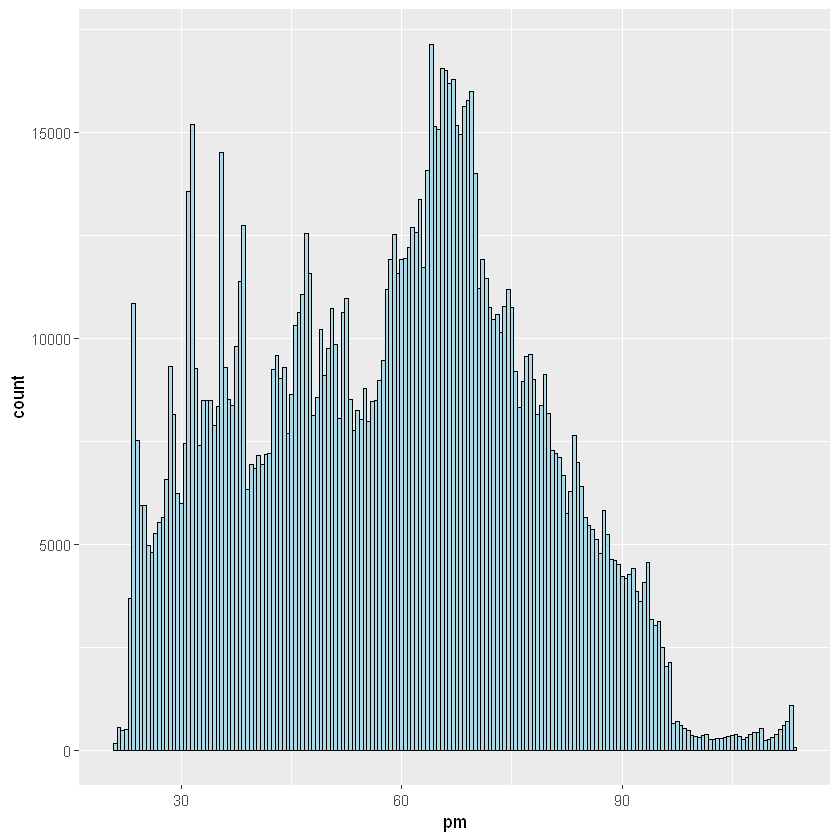

In [13]:
#distribution for the pm
ggplot(df,aes(x=pm))+geom_histogram(binwidth=0.5,fill="lightblue",colour="black")

In [18]:
paste(min(df$pm),max(df$pm))

[1] "20.8569564819336 113.606628417969"

The density curve of pm is a little right skewed, ranges from 20 to 113.

## Step 4: Multiple Linear Regression

### Initial attempt

In [20]:
model1=lm(pm~.,data=df)
model1
summary(model1)


Call:
lm(formula = pm ~ ., data = df)

Coefficients:
   (Intercept)             u_q         coolant  stator_winding             u_d  
    -18.592273       -0.131639       -0.185264       -1.599567       -0.019252  
  stator_tooth     motor_speed             i_d             i_q     stator_yoke  
      3.966738        0.002941        0.042824       -0.010012       -1.571968  
       ambient          torque  
      1.766692        0.005184  



Call:
lm(formula = pm ~ ., data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-45.562  -4.563  -0.453   3.914  40.015 

Coefficients:
                 Estimate Std. Error  t value Pr(>|t|)    
(Intercept)    -1.859e+01  9.405e-02 -197.682  < 2e-16 ***
u_q            -1.316e-01  3.289e-04 -400.283  < 2e-16 ***
coolant        -1.853e-01  1.962e-03  -94.450  < 2e-16 ***
stator_winding -1.600e+00  3.125e-03 -511.813  < 2e-16 ***
u_d            -1.925e-02  2.179e-04  -88.340  < 2e-16 ***
stator_tooth    3.967e+00  7.657e-03  518.050  < 2e-16 ***
motor_speed     2.941e-03  1.316e-05  223.568  < 2e-16 ***
i_d             4.282e-02  3.122e-04  137.179  < 2e-16 ***
i_q            -1.001e-02  1.092e-03   -9.165  < 2e-16 ***
stator_yoke    -1.572e+00  6.824e-03 -230.370  < 2e-16 ***
ambient         1.767e+00  4.156e-03  425.069  < 2e-16 ***
torque          5.184e-03  1.391e-03    3.727 0.000194 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard

It shows all variables are significant in this model. The p-value for the model F-test is very small, which justifies the use of a linear model here.  
The adjusted R-squared value is 0.8549, which means the predictors explain over 85% of the variation in rotor temperature, which is a good result.

### Model diagnostic

(1) Residual Plot to identify non-linearity/heteroscedasticity.

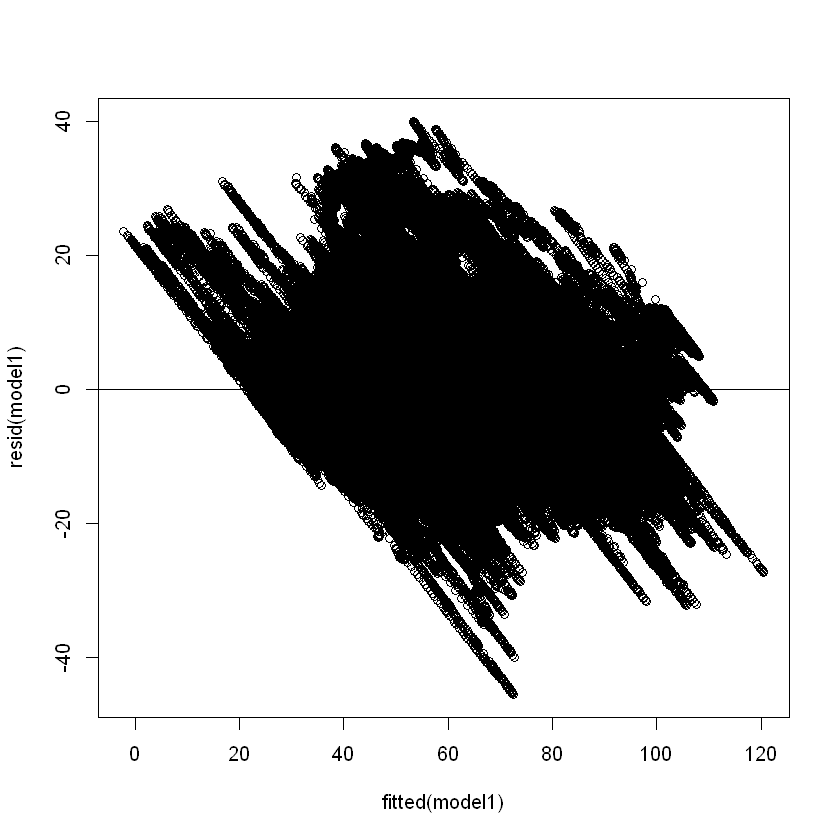

In [26]:
plot(fitted(model1),resid(model1))
abline(h=0)

(2) Correlation of error terms: D-W test & paired scatter plot of residual series.

In [29]:
#D-W test
require(lmtest)
dwtest(pm~.,data=df)


	Durbin-Watson test

data:  pm ~ .
DW = 0.0015506, p-value < 2.2e-16
alternative hypothesis: true autocorrelation is greater than 0



Call:
lm(formula = tail(residuals(model1), n - 1) ~ head(residuals(model1), 
    n - 1))

Residuals:
    Min      1Q  Median      3Q     Max 
-33.847  -0.102  -0.002   0.100  17.504 

Coefficients:
                                Estimate Std. Error   t value Pr(>|t|)    
(Intercept)                    9.735e-06  2.470e-04     0.039    0.969    
head(residuals(model1), n - 1) 9.992e-01  3.413e-05 29279.078   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.2849 on 1330813 degrees of freedom
Multiple R-squared:  0.9985,	Adjusted R-squared:  0.9985 
F-statistic: 8.573e+08 on 1 and 1330813 DF,  p-value: < 2.2e-16


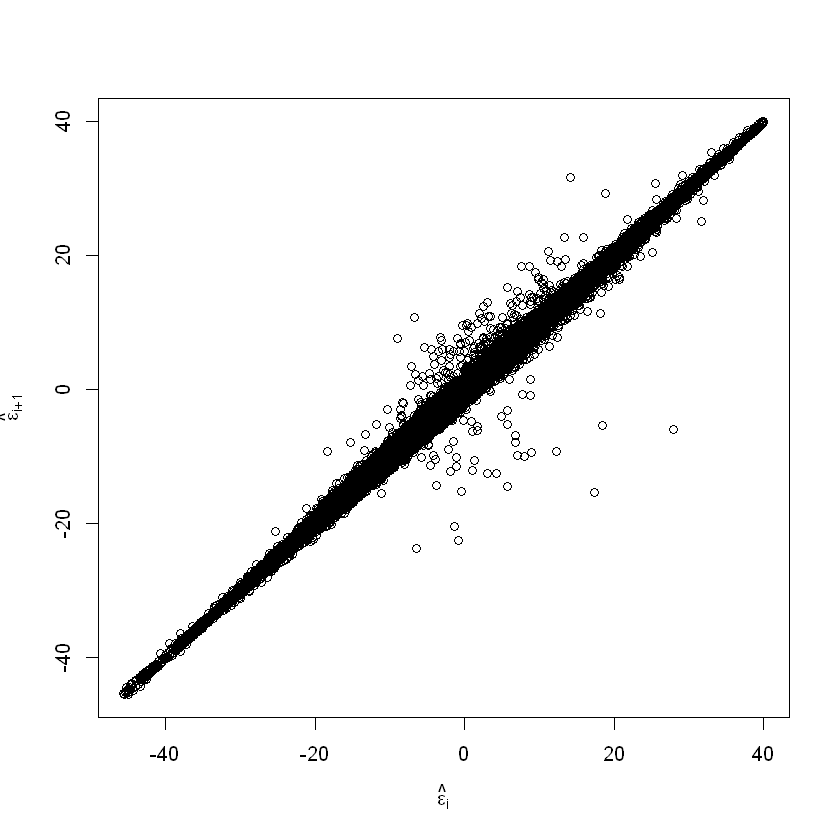

In [30]:
#residual series
n=length(residuals(model1))
plot(tail(residuals(model1),n-1)~head(residuals(model1),n-1),xlab=expression(hat(epsilon)[i]),ylab=expression(hat(epsilon)[i+1]))
summary(lm(tail(residuals(model1),n-1)~head(residuals(model1),n-1)))

The residuals are highly correlated... It may because the measures are recorded in a time sequence.

(3) Normality of residuals

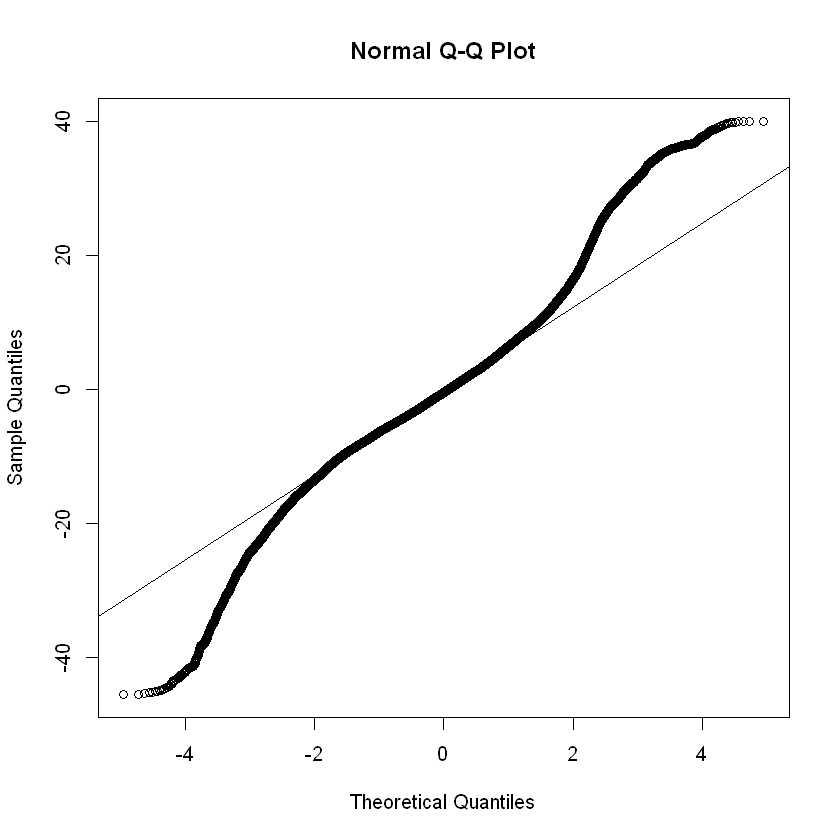

In [31]:
qqnorm(resid(model1))
qqline(resid(model1))

The residuals may not satisfy the normality assumption...

(4) Outliers(yi is far from the predicted value)

In [34]:
stud=rstudent(model1)#studendized residual
stud[which.max(abs(stud))]#the max value
stud[abs(stud)>abs(qt(0.05/(1330816*2),1330804))]#outliers
#abs(qt(0.05/(1330816*2),1330804): the critical value of Bonferroni test: 1330816: sample size, 1330804: degree of freedom

606281 
-6.295885

252299    252300    252301    252302    252303    252304    252305    606245 
 5.508874  5.523772  5.525951  5.529380  5.523391  5.514604  5.505854 -5.523360 
   606246    606247    606248    606249    606250    606251    606252    606253 
-5.537433 -5.556384 -5.580543 -5.570712 -5.555707 -5.552418 -5.580139 -5.604986 
   606254    606255    606256    606257    606258    606259    606260    606261 
-5.622489 -5.659769 -5.709853 -5.757204 -5.748265 -5.743435 -5.752895 -5.733856 
   606262    606263    606264    606265    606266    606267    606268    606269 
-5.717550 -5.728517 -5.728248 -5.733946 -5.747460 -5.762133 -5.791033 -5.813523 
   606270    606271    606272    606273    606274    606275    606276    606277 
-5.830387 -5.864647 -5.910238 -5.914683 -5.877917 -5.859379 -5.874943 -5.988716 
   606278    606279    606280    606281    606282    606283    606284    606285 
-6.117341 -6.217881 -6.292960 -6.295885 -6.273469 -6.252793 -6.236522 -6.200339 
   606286    606287    606288    606289    606290    606291    606292    606293 
-6.150417 -6.085923 -6.013340 -5.945942 -5.881902 -5.822615 -5.777186 -5.745447 
   606294    606295    606296    606297    606298    606299    606300    606301 
-5.738252 -5.735060 -5.745171 -5.773495 -5.803478 -5.837363 -5.864167 -5.915985 
   606302    606303    606304    606305    606306    606307    606308    606309 
-5.974897 -6.033251 -6.084338 -6.133429 -6.167397 -6.198035 -6.220504 -6.241511 
   606310    606311    606312    606313    606314    606315    606316    606317 
-6.150224 -6.063115 -5.999965 -5.965403 -5.969986 -5.976323 -5.963307 -5.948622 
   606318    606319    606320    606321    606322    606323    606324    606325 
-5.900735 -5.844049 -5.801062 -5.768664 -5.723737 -5.690596 -5.679947 -5.682011 
   606326    606327    606328    606329    606330    606331    606332    606333 
-5.673829 -5.678656 -5.680298 -5.693007 -5.712279 -5.724936 -5.714416 -5.693385 
   606334    606335    609327    609328    609329 
-5.666820 -5.613852 -5.519410 -5.536811 -5.526566

The outliers are continuously: 252299-252305, 606245-606335, 609327-609329. I will recommend check if there's some measure error or something else with those samples. With no additional information provided, I will just keep those outliers.

(5) High-leverage points(unusual xi values, tend to have a higher impact on estimated regression line, not necessarily an influential point.

In [ ]:
library(faraway)
hatv=hatvalues(model1)

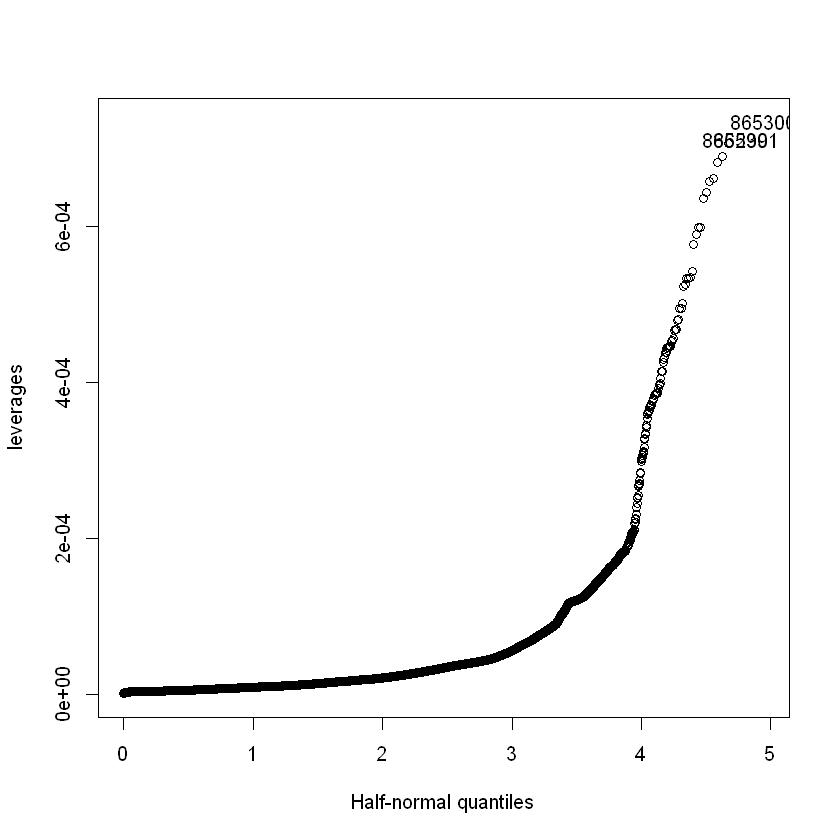

In [40]:
halfnorm(hatv,3,ylab="leverages")

(6) Influential points: observations having a relatively large effect on the regression model's predictions

283720      1048974       157119       927761       881375      1136521 
1.317368e-20 8.089613e-20 2.003018e-19 3.726501e-19 2.276904e-18 3.321860e-18

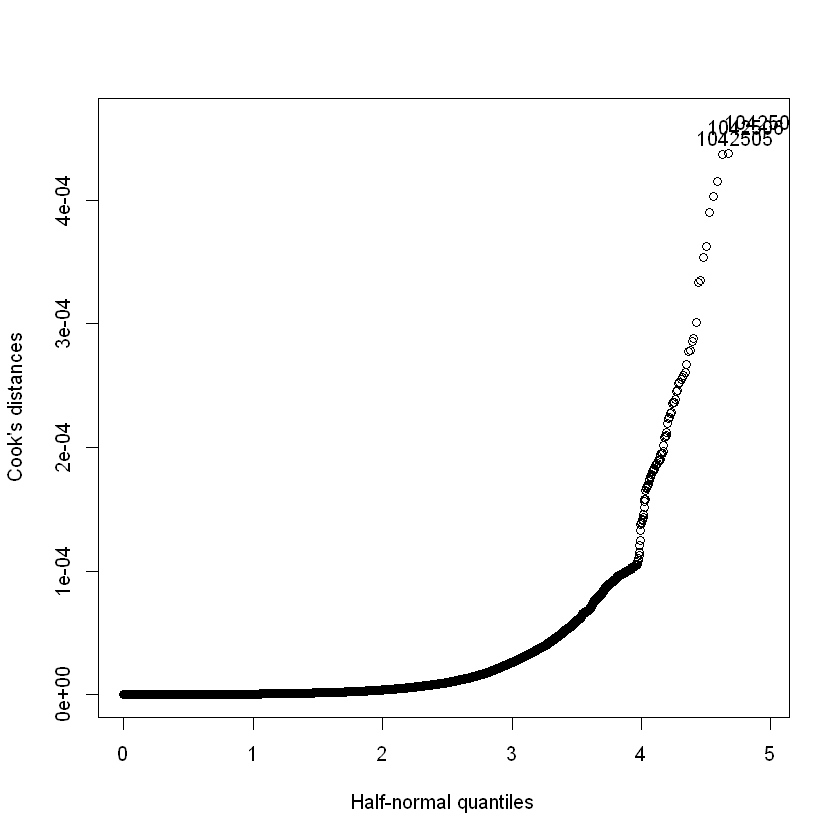

In [41]:
cook=cooks.distance(model1)
head(sort(cook))
halfnorm(cook,3,ylab="Cook's distances")

(7) Collinearity: two or more predictor variables are closely related to one another. 

In [42]:
library(faraway)
x=model.matrix(model1)[,-1]
e=eigen(t(x)%*%x)
e$val
sqrt(e$val[1]/e$val) 
require(faraway)
vif(x)

[1] 1.108381e+13 2.512562e+10 6.835332e+09 3.411148e+09 1.613921e+09
 [6] 3.763353e+08 1.864579e+08 7.553139e+07 1.689323e+07 4.880515e+06
[11] 4.925904e+05

[1]    1.00000   21.00323   40.26843   57.00254   82.87116  171.61571
 [7]  243.81146  383.07232  810.00587 1506.99453 4743.52891

u_q        coolant stator_winding            u_d   stator_tooth 
      5.362333      46.402586     204.034827       4.803940     784.834369 
   motor_speed            i_d            i_q    stator_yoke        ambient 
     15.207705      10.440931     257.681067     472.833428       1.634203 
        torque 
    292.460139

5 variables have VIF>100, which shows that there exists collinearity problem in the model. In the face of collinearity, we may decide to eliminate some variables in the model. 

### Variable Selection

Some measures for the "best model": 

In [45]:
#subset of predictors by # of predictors that produce **min RSS**
require(leaps)
b=regsubsets(pm~.,data=df)
rs=summary(b)
print(rs$which)

  (Intercept)   u_q coolant stator_winding   u_d stator_tooth motor_speed   i_d
1        TRUE FALSE   FALSE          FALSE FALSE         TRUE       FALSE FALSE
2        TRUE FALSE   FALSE          FALSE FALSE         TRUE       FALSE FALSE
3        TRUE FALSE   FALSE           TRUE FALSE         TRUE       FALSE FALSE
4        TRUE  TRUE   FALSE           TRUE FALSE         TRUE       FALSE FALSE
5        TRUE  TRUE   FALSE           TRUE FALSE         TRUE       FALSE FALSE
6        TRUE  TRUE   FALSE           TRUE FALSE         TRUE        TRUE FALSE
7        TRUE  TRUE   FALSE           TRUE FALSE         TRUE        TRUE  TRUE
8        TRUE  TRUE   FALSE           TRUE  TRUE         TRUE        TRUE  TRUE
    i_q stator_yoke ambient torque
1 FALSE       FALSE   FALSE  FALSE
2 FALSE       FALSE    TRUE  FALSE
3 FALSE        TRUE   FALSE  FALSE
4 FALSE        TRUE   FALSE  FALSE
5 FALSE        TRUE    TRUE  FALSE
6 FALSE        TRUE    TRUE  FALSE
7 FALSE        TRUE    TRUE  FALSE


Adjusted R2: 

[1] 8


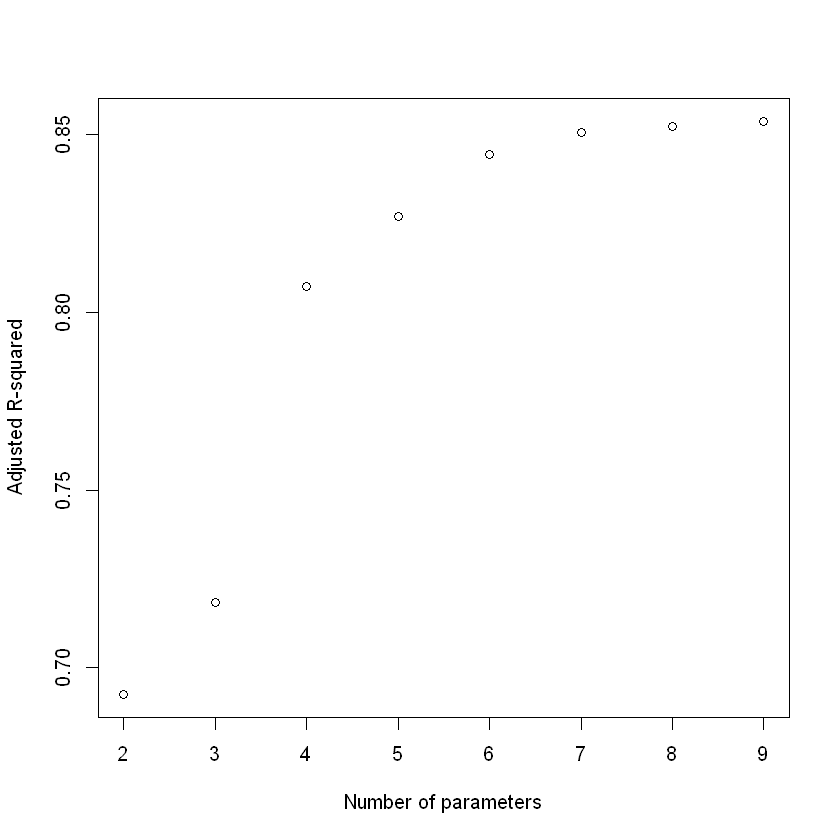

In [55]:
##plot Adjusted R-squared
plot(2:9,rs$adjr2,xlab="Number of parameters",ylab="Adjusted R-squared")
##find the Number of parameters that has max R-squared
print(which.max(rs$adjr2))

8/9 parameters according to Ra^2.

Mallow's CP:

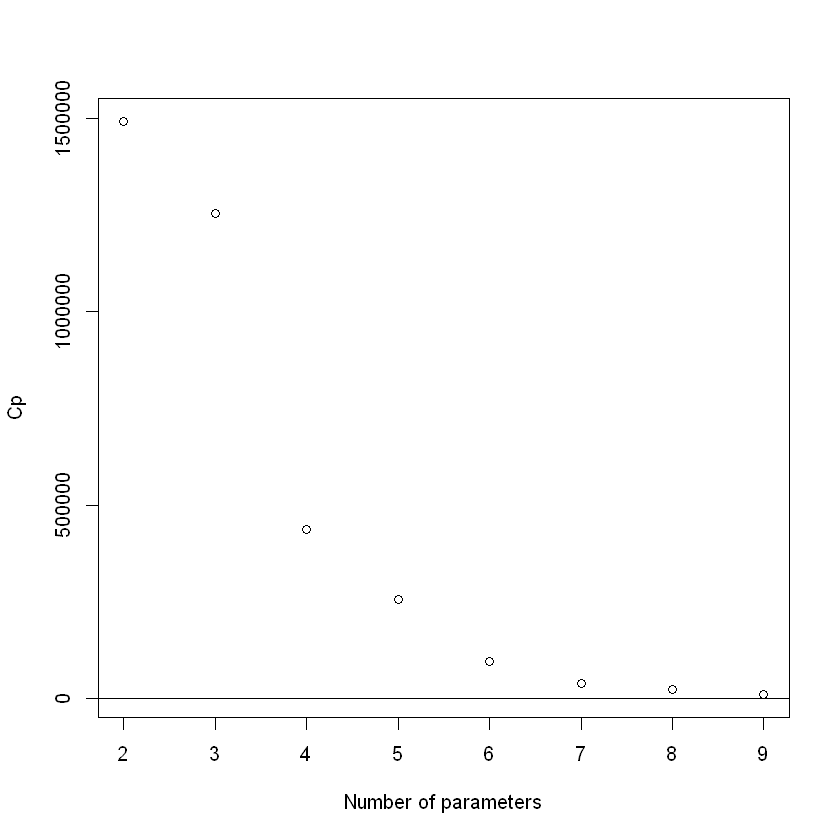

In [57]:
require(leaps)
b=regsubsets(pm~.,data=df)
rs=summary(b)
plot(2:9,rs$cp,xlab="Number of parameters",ylab="Cp")
abline(0,1)

9 parameters according to the Cp.

AIC: 

Warning message in 1330816 * log(rs$rss/1330816) + (2:12) * 2:
"longer object length is not a multiple of shorter object length"


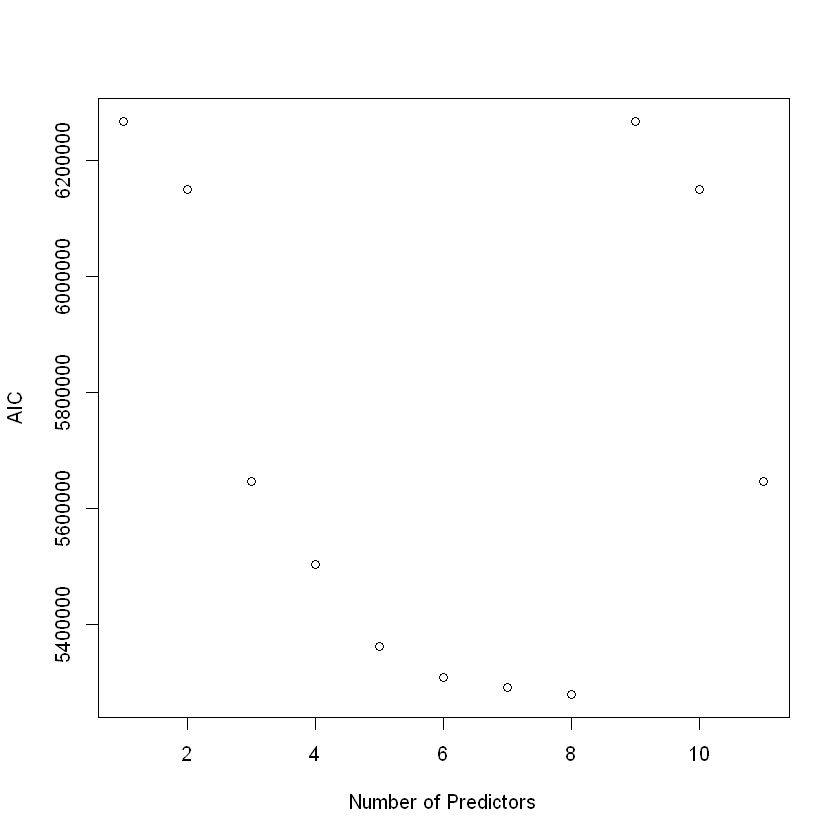

In [67]:
require(leaps)
AIC=1330816*log(rs$rss/1330816)+(2:12)*2
par(mfrow=c(1,1))
plot(AIC~I(1:11),ylab="AIC",xlab="Number of Predictors")

8 predictors according to the AIC.

Therefore, based on these measures, I will choose to keep 8 predictors in the model. And based on the provided model selection matrix which provides min RSS, the predictors would be: u_q, stator_winding, u_d, stator_tooth, motor_speed, i_d, stator_yoke, ambient.

### Model 2 (after variable selection)

In [69]:
model2=lm(pm~u_q+stator_winding+u_d+stator_tooth+motor_speed+i_d+stator_yoke+ambient,data=df)
summary(model2)


Call:
lm(formula = pm ~ u_q + stator_winding + u_d + stator_tooth + 
    motor_speed + i_d + stator_yoke + ambient, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-45.317  -4.606  -0.474   3.960  41.687 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)    -1.859e+01  9.366e-02  -198.4   <2e-16 ***
u_q            -1.308e-01  2.921e-04  -447.8   <2e-16 ***
stator_winding -1.695e+00  2.926e-03  -579.4   <2e-16 ***
u_d            -1.299e-02  1.161e-04  -111.9   <2e-16 ***
stator_tooth    4.472e+00  5.721e-03   781.6   <2e-16 ***
motor_speed     2.816e-03  1.156e-05   243.6   <2e-16 ***
i_d             4.371e-02  3.000e-04   145.7   <2e-16 ***
stator_yoke    -2.173e+00  2.866e-03  -758.2   <2e-16 ***
ambient         1.771e+00  4.155e-03   426.2   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 7.264 on 1330807 degrees of freedom
Multiple R-squared:  0.8538,	Adjusted R-squared:  0.85

Check the collinearity that lies in the model: 

In [70]:
library(faraway)
x=model.matrix(model2)[,-1]
e=eigen(t(x)%*%x)
sqrt(e$val[1]/e$val) 
require(faraway)
vif(x)

[1]    1.00000   40.06116   46.09802   65.68778  142.67295  381.35313  515.02934
[8] 3132.47396

u_q stator_winding            u_d   stator_tooth    motor_speed 
      4.198861     177.449370       1.353142     434.815413      11.654233 
           i_d    stator_yoke        ambient 
      9.570149      82.786412       1.621185

There's still collinearity that exists in the model, especially for **stator_tooth**. I would remove it and check again.

### Model 3

In [71]:
model3=lm(pm~u_q+stator_winding+u_d+motor_speed+i_d+stator_yoke+ambient,data=df)
summary(model3)


Call:
lm(formula = pm ~ u_q + stator_winding + u_d + motor_speed + 
    i_d + stator_yoke + ambient, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-56.534  -5.826  -0.429   5.344  41.423 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)    -3.222e+01  1.112e-01 -289.86   <2e-16 ***
u_q            -1.816e-01  3.440e-04 -527.87   <2e-16 ***
stator_winding  5.192e-01  8.820e-04  588.66   <2e-16 ***
u_d            -2.216e-02  1.395e-04 -158.86   <2e-16 ***
motor_speed     7.909e-03  1.153e-05  685.71   <2e-16 ***
i_d             1.686e-01  3.068e-04  549.48   <2e-16 ***
stator_yoke    -4.837e-02  1.097e-03  -44.08   <2e-16 ***
ambient         2.527e+00  4.881e-03  517.68   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 8.775 on 1330808 degrees of freedom
Multiple R-squared:  0.7867,	Adjusted R-squared:  0.7867 
F-statistic: 7.014e+05 on 7 and 1330808 DF,  p-value: < 2.2e-16


In [72]:
library(faraway)
x=model.matrix(model3)[,-1]
e=eigen(t(x)%*%x)
sqrt(e$val[1]/e$val) 
require(faraway)
vif(x)

[1]   1.00000  42.03800  51.56723  66.37555 145.43785 382.65705 515.72939

u_q stator_winding            u_d    motor_speed            i_d 
      3.991220      11.054278       1.339321       7.951452       6.857530 
   stator_yoke        ambient 
      8.317337       1.533346

There's no collinearity concern now, but the R-squared value has dropped a lot(below 80%)! emmm. It seems that the stator_tooth plays a rather important role with the response variable here...Okay I will put it back and remove the variable with the second biggest VIF, which is stator_winding.

### Model 4 - the final model for the MLR

In [73]:
model4=lm(pm~u_q+u_d+motor_speed+i_d+stator_yoke+ambient+stator_tooth,data=df)
summary(model4)


Call:
lm(formula = pm ~ u_q + u_d + motor_speed + i_d + stator_yoke + 
    ambient + stator_tooth, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-54.433  -5.249  -0.531   4.833  40.175 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -3.029e+01  1.023e-01  -295.9   <2e-16 ***
u_q          -1.681e-01  3.188e-04  -527.4   <2e-16 ***
u_d          -1.748e-02  1.296e-04  -134.8   <2e-16 ***
motor_speed   6.644e-03  1.062e-05   625.9   <2e-16 ***
i_d           1.547e-01  2.583e-04   599.0   <2e-16 ***
stator_yoke  -7.664e-01  1.705e-03  -449.6   <2e-16 ***
ambient       2.388e+00  4.495e-03   531.2   <2e-16 ***
stator_tooth  1.262e+00  1.598e-03   789.6   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 8.129 on 1330808 degrees of freedom
Multiple R-squared:  0.817,	Adjusted R-squared:  0.817 
F-statistic: 8.486e+05 on 7 and 1330808 DF,  p-value: < 2.2e-16


In [74]:
library(faraway)
x=model.matrix(model4)[,-1]
e=eigen(t(x)%*%x)
sqrt(e$val[1]/e$val) 
require(faraway)
vif(x)

[1]   1.00000  42.87330  54.07453  65.87181 143.75030 393.65992 939.85717

u_q          u_d  motor_speed          i_d  stator_yoke      ambient 
    3.994664     1.347125     7.847733     5.665940    23.388582     1.514883 
stator_tooth 
   27.086998

Now we got a model with lower R-squared value, but it is acceptable since the collinearity has been eliminated here. 

### Cross-validation to check the model's performance in prediction

https://www.rdocumentation.org/packages/lmvar/versions/1.5.2/topics/cv.lm

In [90]:
library(DAAG)

In [97]:
MLR<-lm(pm~u_q+u_d+motor_speed+i_d+stator_yoke+ambient+stator_tooth,data=df, x = TRUE, y = TRUE)

In [98]:
cv.lm(df=df,MLR)

Mean absolute error        :  6.202322 
Sample standard deviation  :  0.02414958 

Mean squared error         :  66.08449 
Sample standard deviation  :  0.5892648 

Root mean squared error    :  8.129164 
Sample standard deviation  :  0.03626784 


## Step 5: Principal Component Regression

Since there are collinearity exists in the predictors, I will also try a principal component regression.

In [110]:
df[,-c('pm')]

ERROR: Error in -c("pm"): invalid argument to unary operator


In [105]:
pca <- prcomp(df[,-c('pm')], scale.=TRUE)

ERROR: Error in -c("pm"): invalid argument to unary operator
